In [1]:

import numpy as np
import torch
import time
from torch import nn
import gym
import cv2
import copy
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm


DEFINING THE ENVIRONMENT

In [2]:

#env = gym.make('BreakoutDeterministic-v4')
#env = gym.make('ALE/Seaquest-v5')
#env = gym.make('ALE/Qbert-v5')
env = gym.make('ALE/SpaceInvaders-v5')
print(env.action_space)


Discrete(6)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


HYPER PARAMETERS

In [3]:
feedback = 4
frame_skip = 3
Anneal = 50000 
epsilon = lambda step: np.clip(1 - 0.9 * (step/Anneal), 0.1, 1) 
Number_Of_Episodes = 1000
Maximum_Number_Of_Steps_In_A_Episode = 1000
Experience_replay_highest_storage_capacity = 10000 
Number_Of_Actions = env.action_space.n 
Batch_Size = 32
LR = 2.5e-4
Intervals = 100

IMAGE PREPROCESSING

In [4]:


def IMAGE_PROCESSSING(Observation, Cropping_image_to=(84, 110), Image_size=None):
    assert(type(Observation) == np.ndarray), "The observation must be a numpy array!"
    assert(len(Observation.shape) == 3), "The observation must be a 3D array!"

    Observation = cv2.resize(Observation, Cropping_image_to, interpolation=cv2.INTER_LINEAR)
    Observation = cv2.cvtColor(Observation, cv2.COLOR_BGR2GRAY)
    Observation = Observation / 255.
    if Image_size:
        Remove_Borders_in_width = (Cropping_image_to[1] - Image_size[1]) // 2
        Remove_Borders_in_height = (Cropping_image_to[0] - Image_size[0]) // 2
        
        begining_of_width, end_of_width = Remove_Borders_in_width, Cropping_image_to[1] - Remove_Borders_in_width
        begining_of_height, end_of_height = Remove_Borders_in_height, Cropping_image_to[0] - Remove_Borders_in_height
        
        Observation = Observation[begining_of_width:end_of_width, begining_of_height:end_of_height]
    
    return Observation

def STACKING_IMAGE_TOGETHER(Observation, before_image):
    if not before_image:
        before_image = [Observation] * (3)
        
    before_image.append(Observation)
    clubed_image = np.stack(before_image)
    before_image = before_image[-(3):]
    
    return clubed_image, before_image

def FINAL_RESULT_FOR_FEEDING_TO_CNN(Observation, before_image):
    Final_result_of_the_observation = IMAGE_PROCESSSING(Observation)
    clubed_result, before_image = STACKING_IMAGE_TOGETHER(Final_result_of_the_observation, before_image)
    return clubed_result, before_image

def Selection_of_rew(rew):
    if rew > 0:
        return 1
    elif rew < 0:
        return -1
    return 0


IMPLEMENTING THE DQN AGENT

In [5]:
class DQN(nn.Module):
    def __init__(self, Number_Of_Actions):
        super(DQN, self).__init__()
        
        self.L1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=8, stride=4, padding=0),
            nn.ReLU())
        self.L2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU())
        self.Linear_layer = nn.Sequential(
            nn.Linear(32 * 12 * 9, 256),
            nn.ReLU())
        self.L3 = nn.Sequential(
            nn.Linear(256, Number_Of_Actions))
        
    def forward(self, Observation):
        state = self.L1(Observation)
        state = self.L2(state)
        state = state.view(-1, 32 * 12 * 9)
        state = self.Linear_layer(state)
        state = self.L3(state)
        return state
    
    def BATCH(self, optimizer, Observation, acts, rewards, nextstate, terminals, gamma=1.0):
        
        next_state = self.forward(nextstate)
        max_next_state = torch.max(next_state, dim=1)[0].detach()
        
        final_state = 1 - terminals
        known_qvalue = rewards + final_state * gamma * max_next_state
            
        estimated_qvalue = self.forward(Observation)
        estimated_qvalue = estimated_qvalue.gather(index=acts.view(-1, 1), dim=1).view(-1)
        
        loss = torch.mean((known_qvalue - estimated_qvalue) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


EXPERIENCE REPLAY

In [6]:

class EXPERIENCE_REPLAY():
    def __init__(self, maximum_storage):
        self.maximum_storage = maximum_storage
        self.data = []
        
    def Appending_the_data(self, addon):
        self.data.append(addon)
        if len(self.data) > self.maximum_storage:
            self.data = self.data[-self.maximum_storage:]
            
    def Storage(self, n):
        n = min(n, len(self.data))
        selection = np.random.choice(range(len(self.data)), n, replace=False)
        solutions = np.asarray(self.data)[selection]
        
        presentstate = torch.tensor(np.stack(solutions[:, 0])).float().cpu()
        actiontaken = torch.tensor(np.stack(solutions[:, 1])).long().cpu()
        Obtainedrew = torch.tensor(np.stack(solutions[:, 2])).float().cpu()
        upcomingstate = torch.tensor(np.stack(solutions[:, 3])).float().cpu()
        info = torch.tensor(np.stack(solutions[:, 4])).float().cpu()
        
        return presentstate, actiontaken, Obtainedrew, upcomingstate, info


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/jd/mdg1f1x937q_vg_xlpcw1c4c0000gn/T/ipykernel_55074/589511636.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  solutions = np.asarray(self.data)[selection]
  0%|          | 1/1000 [00:02<42:43,  2.57s/it]

Episode #0 | Step #233 | Epsilon 1.00 | Average_Rewards215.00


  0%|          | 2/1000 [00:03<29:20,  1.76s/it]/var/folders/jd/mdg1f1x937q_vg_xlpcw1c4c0000gn/T/ipykernel_55074/3711458623.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  obs_tensor = torch.tensor([Observation]).float().cpu()
 10%|█         | 101/1000 [03:39<33:03,  2.21s/it]

Episode #100 | Step #17919 | Epsilon 0.68 | Average_Rewards143.20


 20%|██        | 201/1000 [07:59<41:50,  3.14s/it]

Episode #200 | Step #37279 | Epsilon 0.33 | Average_Rewards149.00


 30%|███       | 301/1000 [13:11<33:28,  2.87s/it]

Episode #300 | Step #59348 | Epsilon 0.10 | Average_Rewards160.95


 40%|████      | 401/1000 [18:16<28:03,  2.81s/it]

Episode #400 | Step #80710 | Epsilon 0.10 | Average_Rewards123.80


 50%|█████     | 501/1000 [23:26<32:05,  3.86s/it]

Episode #500 | Step #102413 | Epsilon 0.10 | Average_Rewards144.00


 60%|██████    | 601/1000 [28:11<19:57,  3.00s/it]

Episode #600 | Step #123267 | Epsilon 0.10 | Average_Rewards148.05


 70%|███████   | 701/1000 [33:16<11:21,  2.28s/it]

Episode #700 | Step #145393 | Epsilon 0.10 | Average_Rewards168.30


 80%|████████  | 801/1000 [37:58<09:03,  2.73s/it]

Episode #800 | Step #165376 | Epsilon 0.10 | Average_Rewards102.35


 90%|█████████ | 901/1000 [42:40<04:16,  2.59s/it]

Episode #900 | Step #185126 | Epsilon 0.10 | Average_Rewards116.35


100%|██████████| 1000/1000 [47:40<00:00,  2.86s/it]


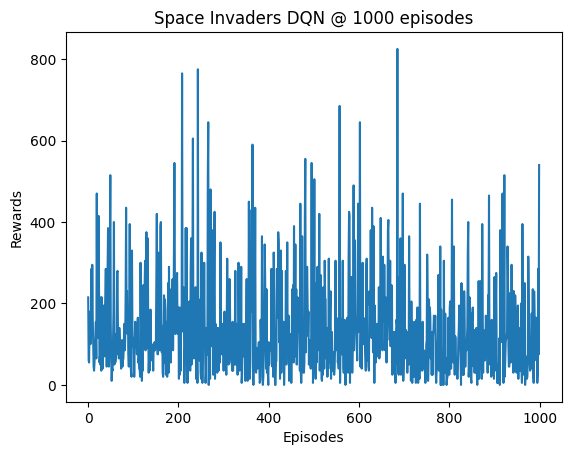

In [7]:
ExperienceR = EXPERIENCE_REPLAY(Experience_replay_highest_storage_capacity)
model = DQN(Number_Of_Actions=env.action_space.n).cpu()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, eps=1e-6)
accumulatedrew = []
cummulativesteps = 0

for episode in tqdm(range(Number_Of_Episodes)):
    before_image = []
    Observation, before_image = FINAL_RESULT_FOR_FEEDING_TO_CNN(env.reset(), before_image)
    
    episode_reward = 0
    step = 0
    while step < Maximum_Number_Of_Steps_In_A_Episode:

        ### Enact a step ###
        
        if np.random.rand() < epsilon(cummulativesteps):
            act = np.random.choice(range(Number_Of_Actions))
        else:
            obs_tensor = torch.tensor([Observation]).float().cpu()
            state = model(obs_tensor)[0]
            state = state.cpu().detach().numpy()
            act = np.argmax(state)
        
        cumulative_reward = 0
        for _ in range(frame_skip):
            nextstate, rew, done, _ = env.step(act)
            cumulative_reward += rew
            if done or step >= Maximum_Number_Of_Steps_In_A_Episode:
                break
        episode_reward += cumulative_reward
        rew = Selection_of_rew(cumulative_reward)
        nextstate, before_image = FINAL_RESULT_FOR_FEEDING_TO_CNN(nextstate, before_image)
        ExperienceR.Appending_the_data([Observation, act, rew, nextstate, int(done)])
        Observation = nextstate
        
        ### Train on a minibatch ###

        if cummulativesteps % feedback == 0:
            environmentdata, actiontaken, Obtainedrew, next_obs_data, info = ExperienceR.Storage(Batch_Size)
            model.BATCH(optimizer, environmentdata, actiontaken, Obtainedrew, next_obs_data, info)
        
        step += 1
        cummulativesteps += 1
        
        if done:
            break
            
    accumulatedrew.append(episode_reward)


    
    if episode % Intervals == 0:

        print('Episode #{} | Step #{} | Epsilon {:.2f} | Average_Rewards{:.2f}'.format(
            episode, cummulativesteps, epsilon(cummulativesteps), np.mean(accumulatedrew[-Intervals:])))


plt.plot(accumulatedrew)
#add a title
plt.title('Space Invaders DQN @ 1000 episodes')
#add a label to the x-axis
plt.xlabel('Episodes')
#add a label to the y-axis
plt.ylabel('Rewards')
plt.show()




     
